# (Pseudo) CyCADA

> First attempt at using segmentation labels to guide the CycleGAN process. It's a (pseudo) CyCADA because we will be using the labels from the real dataset instead of using the labels from the original simulated domain.

```mermaid
flowchart LR

A[Original Image] --> B[Transformed Image]

```

In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from pathlib import Path
from itertools import product
import re
from typing import Tuple
from tqdm.auto import tqdm
import time
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import wandb

from tensorflow_examples.models.pix2pix import pix2pix

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

## Data Loading

### CityScapes

The different training, validation and test subsets are divided in their correspondent folders:

In [4]:
path_root = Path("/media/disk/databases/dn_segmentation/cityscapes")
path_train = path_root / "train_data"
path_val = path_root / "validation_data"
path_test = path_root / "test_data"

We will now build a set of generators to load the data:

In [5]:
def get_label_path_from_img(path_img):
    path_label = str(path_img).split("_")
    path_label[-1] = "gtFine_color.png"
    path_label = "_".join(path_label)
    path_label = path_label.replace("images", "labels")
    path_label = Path(path_label)
    return path_label

In [6]:
def load_img_label(path_img, path_label, size: Tuple = (256,256)):
    ## Load the images
    img = cv2.imread(str(path_img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=size)
    label = cv2.imread(str(path_label))
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
    label = cv2.resize(label, dsize=size, interpolation=cv2.INTER_NEAREST)
    return img, label

In [7]:
def train_gen():
    for path_img in (path_train/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)
        yield load_img_label(path_img, path_label)

In [1]:
a, b = next(train_gen())
a.shape, b.shape

((256, 256, 3), (256, 256, 3))

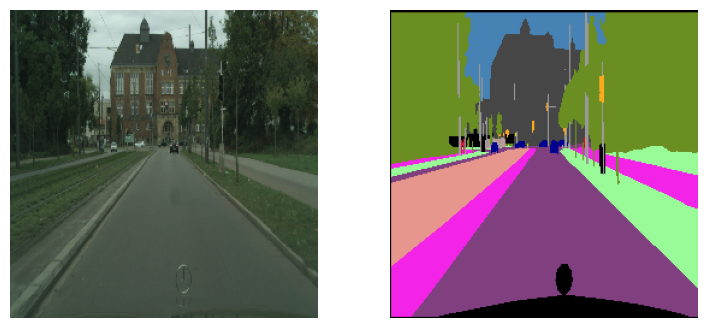

In [9]:
fig, axes = plt.subplots(1,2,figsize=(9,4))

axes[0].imshow(a)
axes[1].imshow(b)
for ax in axes: ax.axis("off")
plt.show()

### GTA

In [10]:
root_gta = Path("/media/disk/databases/dn_segmentation/gta")
gta_images = root_gta / "images"
gta_labels = root_gta / "labels"

In [11]:
def generator_gta():
    """Yields images and labels from the GTA dataset."""
    for path_img in gta_images.glob("*/*.png"):
        path_img = str(path_img)
        path_label = re.sub("images", "labels", path_img)
        yield load_img_label(path_img, path_label)

In [2]:
a, b = next(generator_gta())
a.shape, b.shape

((256, 256, 3), (256, 256, 3))

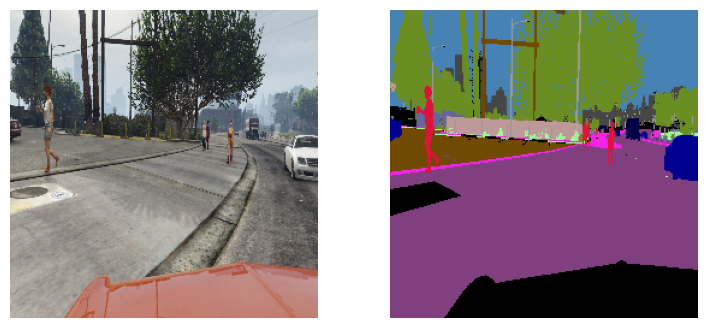

In [13]:
fig, axes = plt.subplots(1,2,figsize=(9,4))

axes[0].imshow(a)
axes[1].imshow(b)
for ax in axes: ax.axis("off")
plt.show()

### Turn the labels into a sparse representation

> The labels are loaded as colors, but now we need to turn them into sparse representations to be able to train our network.

First we will be obtaining the individual colors in the images:

In [3]:
colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), 
                   (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), 
                   (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), 
                   (119, 11, 32), (0, 0, 142)], dtype = np.int32)
# colors = set([tuple(c) for c in colors])
colors = [tuple(c) for c in colors]
len(colors)

30

Now we can build a dictionary mapping each color into one integer:

In [4]:
color2label = {color:i for i,color in enumerate(colors)}
label2color = {i:color for i,color in enumerate(colors)}
len(color2label)#, label2color

29

Finally, we can convert the label:

In [16]:
def prepare_label(label):
    new_label = np.empty(shape=label.shape[:-1])
    for i, j in product(range(label.shape[0]), range(label.shape[1])):
        color = label[i,j]
        new_label[i,j] = color2label[tuple(color)]
    return new_label

In [17]:
def prepare_label_one_hot(label):
    new_label = np.zeros(shape=(*label.shape[:-1], len(colors)))
    for i, j in product(range(label.shape[0]), range(label.shape[1])):
        color = label[i,j]
        idx = color2label[tuple(color)]
        new_label[i,j,idx] = 1
    return new_label

In [18]:
def one_hot_to_sparse(label):
    """Turns a one-hot encoded label into a sparse one."""
    return np.argmax(label, axis=-1)

## Building the `Dataset`'s

> We'll use `albumentations` to perform the mask-aware augmentation of the data.

In [19]:
def renormalize(img, contrast=1):
    return img*0.5*contrast + 0.5

In [20]:
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5)
])

In [21]:
def generator_cityscapes():
    for path_img in (path_train/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)
        img, label = load_img_label(path_img, path_label, size=(286,286))
        img = (img/127.5) - 1

        ## Augment the data
        transformed = transform(image=img, mask=label)
        img, label = transformed["image"], transformed["mask"]

        ## Prepare the labels
        label = prepare_label_one_hot(label)
        
        yield img, label

In [22]:
def generator_gta():
    """Yields images and labels from the GTA dataset. LABEL IS NOT USABLE."""
    for path_img in gta_images.glob("*/*.png"):
        path_img = str(path_img)
        path_label = re.sub("images", "labels", path_img)
        img, label = load_img_label(path_img, path_label, size=(286,286))
        img = (img/127.5) - 1
        
        ## Augment the data
        transformed = transform(image=img, mask=label)
        img, label = transformed["image"], transformed["mask"]
        
        ## (Skip because we don't need the labels right now) Prepare the labels
        # label = prepare_label_one_hot(label)
        
        yield img, label

In [5]:
a, b = next(generator_cityscapes())
a.shape, b.shape

((256, 256, 3), (256, 256, 30))

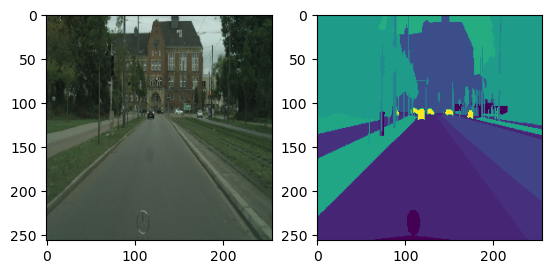

In [24]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(renormalize(a))
axes[1].imshow(one_hot_to_sparse(b))
plt.show()

In [25]:
dst_cityscapes = tf.data.Dataset.from_generator(
                            generator_cityscapes,
                            output_signature=(
                                tf.TensorSpec(a.shape, tf.float32),
                                tf.TensorSpec(b.shape, tf.int32),
                            ))

2022-11-28 13:16:43.236121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:84:00.0, compute capability: 3.5


In [6]:
a, b = next(generator_gta())
a.shape, b.shape

((256, 256, 3), (256, 256, 3))

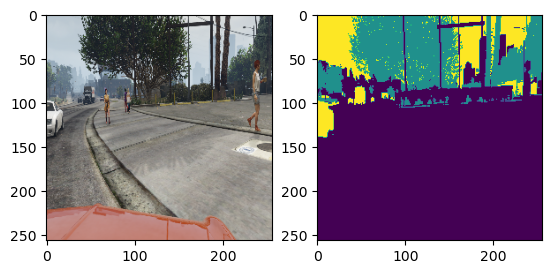

In [27]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(renormalize(a))
axes[1].imshow(one_hot_to_sparse(b))
plt.show()

In [28]:
dst_gta = tf.data.Dataset.from_generator(
                            generator_gta,
                            output_signature=(
                                tf.TensorSpec(a.shape, tf.float32),
                                tf.TensorSpec(b.shape, tf.int32),
                            ))

Put the datasets together:

In [7]:
for (a1,b1), (a2,b2) in zip(dst_gta, dst_cityscapes):
    break
a1.shape, b1.shape, a2.shape, b2.shape

(TensorShape([256, 256, 3]),
 TensorShape([256, 256, 3]),
 TensorShape([256, 256, 3]),
 TensorShape([256, 256, 30]))

## Preprocesado de los datos

Finalmente, antes de poder entrenar el modelo con nuestros datos, aplicaremos algnuas transformaciones a los datos:

- Normalización entre $[-1,1]$: Facilita la convergencia del modelo y ha demostrado mejores resultados en GANs que la normalización $[0,1]$.
- Cambio de tamaño: Las imágenes que hemos cargado son excesivamente grandes, así que reduciremos su tamaño para acelerar el entrenamiento de los modelos. Hay que recordar que ahora mismo lo que queremos es una prueba de concepto, por lo que no necesitamos trabajar con la máxima resolución disponible.

También podemos aplicar algunas técnicas de aumento de datos para aportar más variabilidad al conjunto de entrenamiento y reducir el sobreajuste del modelo:

- Troceado aleatorio: De cada imagen se extrae un fragmento aleatorio para aumentar la variabilidad del conjunto de datos.
- Volteado aleatorio: Con el mismo objetivo, también se voltean horizontalmente las imágenes.

In [30]:
# def preprocess_imgs(img, label):
#     ## Convertimos las imágenes de int a float

#     ## Normalizamos al rango [-1,1]
#     img = (img/127.5) - 1

#     img, label = tf.numpy_function(transform_fn, inp=[img, label], Tout=tf.float32)
#     img, label = tf.cast(img, tf.float32), tf.cast(label, tf.float32)
#     return img, label

In [31]:
# dataset_gta_rdy = dst_gta.map(preprocess_imgs)
# dataset_cityscapes_rdy = dst_cityscapes.map(preprocess_imgs)

In [32]:
dst_gta_rdy = dst_gta
dst_cityscapes_rdy = dst_cityscapes

## Uniendo los `Dataset`

Una vez hemos definido los dos `Dataset` que necesitamos, podemos unirlos utilizando el método `.zip()` para obtener un único `Dataset` que nos devuelva un elemento de cada conjunto. Esto hace más cómodo su uso posterior.

In [33]:
dst_full = tf.data.Dataset.zip((dst_gta_rdy, dst_cityscapes_rdy.shuffle(buffer_size=10).repeat()))

In [8]:
for (img_gta, label_gta), (img_cityscapes, label_cityscapes) in dst_full:
    break
img_gta.shape, label_gta.shape, img_cityscapes.shape, label_cityscapes.shape

(TensorShape([256, 256, 3]),
 TensorShape([256, 256, 3]),
 TensorShape([256, 256, 3]),
 TensorShape([256, 256, 30]))

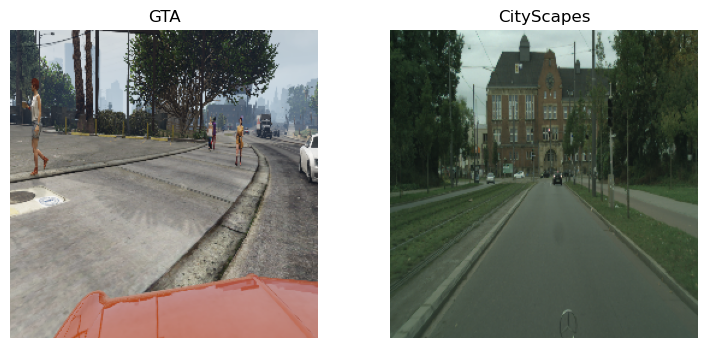

In [35]:
fig, axes = plt.subplots(1,2, figsize=(9,4))

axes[0].imshow(renormalize(img_gta))
axes[0].set_title("GTA")
axes[1].imshow(renormalize(img_cityscapes))
axes[1].set_title("CityScapes")

for ax in axes.ravel():
    ax.axis('off')

plt.show()

## Set up the labeler

> We need an already trained segmentation model to produce labels in order to guide our style transfer network.

In [36]:
from unet import build_unet

In [37]:
unet = build_unet(shape=(256,256,3), path_weights="model_segmentation.h5")
for layer in unet.layers: layer.trainable = False

## Función de coste

Lo único que nos queda por definir es la función de coste:

In [38]:
LAMBDA = 10 # Es el valor que usan en el paper original

In [39]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_segmentation = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [40]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [41]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [42]:
def calc_cycle_loss(real_image, cycled_image):
  real_image, cycled_image = tf.cast(real_image, tf.float32), tf.cast(cycled_image, tf.float32)
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [43]:
def identity_loss(real_image, same_image):
  real_image, same_image = tf.cast(real_image, tf.float32), tf.cast(same_image, tf.float32)
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [44]:
def labeler_loss_cityscapes(cityscapes_image, true_label):
    """GTA -> CityScapes -> Segmentation -> Loss (Ground Truth, Segmentation)"""
    pred_label = unet(cityscapes_image, training=False)
    return loss_segmentation(true_label, pred_label)

## CycleGAN Model

In [45]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

## Optimizadores

Utilizamos el mismo optimizador (*Adam*) y los mismos parámetros que en el paper original:

In [46]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

Al entrenar modelos de este tipo que tienen un tiempo de ejecución muy alto, es muy recomendable utilizar algún tipo de *Checkpoint* que nos permita ir guardando el estado del modelo durante el entrenamiento. De esta forma podremos continuar el entrenamiento si se nos para a mitad o, en el caso de que nuestro modelo sufra de *overfit*, podemos elegir un estado anterior que esté mejor ajustado a los datos.

Al utilizar optimizadores con decaimiento en los pesos (como Adam), es recomendable no guardar únicamente los pesos del modelo, si no también el estado del propio optimizador. Si no lo hacemos, al recuperar el entrenamiento no seguiremos exactamente por dónde lo habíamos dejado y podemos tener algún problema.

Una herramienta muy cómoda que tenemos a nuestra disposición es el `tf.train.CheckpointManager`, que se ocupa automáticamente de gestionar los checkpoints y, además, recupera un checkpoint anterior automáticamente si lo hubiese.

In [47]:
checkpoint_path = "./Checkpoints/"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

In [48]:
def generate_images(model, test_input, show=False):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(renormalize(display_list[i]))
    plt.axis('off')
  if show: plt.show()

In [49]:
@tf.function
def train_step(real_x, real_y, label_x, label_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y [X is GTA / Y is CityScapes]
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    cycle_loss_x = calc_cycle_loss(real_x, cycled_x)
    cycle_loss_y = calc_cycle_loss(real_y, cycled_y)

    total_cycle_loss = cycle_loss_x + cycle_loss_y

    ## Segmentation model loss
    segmentation_loss = labeler_loss_cityscapes(fake_y, label_y)
    
    ## Identity losses
    identity_loss_x = identity_loss(real_x, same_x)
    identity_loss_y = identity_loss(real_y, same_y)

    # Total generator loss = adversarial loss + cycle loss + identity loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss_y + segmentation_loss
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss_x

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

  return {
    "gen_g_loss": gen_g_loss,
    "gen_f_loss": gen_f_loss,
    "total_cycle_loss": total_cycle_loss,
    "segmentation_loss": segmentation_loss,
    "identity_loss_x": identity_loss_x,
    "identity_loss_y": identity_loss_y,
    "cycle_loss_x": cycle_loss_x,
    "cycle_loss_y": cycle_loss_y,
    "disc_x_loss": disc_x_loss,
    "disc_y_loss": disc_y_loss,
  }

In [50]:
config = dict(EPOCHS = 1,
              BATCH_SIZE = 1,
              SAVE_EACH_EPOCHS = 2, ## Indica cada cuántas épocas queremos guardar un Checkpoint
              LOG_EACH_BATCH = 200,
              SAVE = False,
)

In [51]:
wandb.init(project="CyCADA",
           config=config,
           job_type="testing",
           mode="online",
           )
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgvt. Use `wandb login --relogin` to force relogin


In [ ]:
batches_seen = 0
for epoch in tqdm(range(config.EPOCHS), desc="Épocas"):
  start = time.time()

  n = 0
  for (image_x, label_x), (image_y, label_y) in tqdm(dst_full.shuffle(buffer_size=10, reshuffle_each_iteration=True)\
                                                             .batch(1),#\
                                                            #  .take(1),
                                                            #  .prefetch(tf.data.AUTOTUNE), 
                                                     desc="Batch", leave=False, total=24964//config.BATCH_SIZE): # En el paper original dicen que usan un batch de 1
    losses = train_step(image_x, label_x, image_y, label_y)
    ## Comentado porque hemos cambiado por TQDM
    # if n % 10 == 0:
    #   print ('.', end='')
    # n+=1

    if batches_seen % config.LOG_EACH_BATCH == 0:
      generate_images(generator_g, img_gta[None,:], show=False)
      losses["res_imgs"] = plt
      wandb.log(losses, step=batches_seen)
      plt.close()
    batches_seen += 1
  
  if not config.SAVE: continue
  if (epoch + 1) % config.SAVE_EACH_EPOCHS == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Épocas: 100%|##########| 1/1 [7:29:26<00:00, 26966.97s/it]


In [53]:
wandb.finish()

<class 'TypeError'>: get_range() missing 1 required positional argument: 'session'